In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import os, re
import statsmodels.formula.api as smf

In [3]:
def load_stock(file, name):
    df = pd.read_excel(file)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Company"] = name
    return df[["Date", "Company", "PX_LAST", "CHG_PCT_1D", "VOLATILITY_30D", "PX_VOLUME"]]

byd     = load_stock("BYD.xlsx", "BYD")
lucid   = load_stock("LUCID.xlsx", "Lucid")
nio     = load_stock("NIO.xlsx", "NIO")
rivian  = load_stock("Rivian.xlsx", "Rivian")
tesla   = load_stock("TESLA.xlsx", "Tesla")

# Combine all into one DataFrame
stocks = pd.concat([byd, lucid, nio, rivian, tesla], ignore_index=True)

In [4]:
stocks.head()

,Date,Company,PX_LAST,CHG_PCT_1D,VOLATILITY_30D,PX_VOLUME
0,2025-07-31,BYD,14.70064,-4.5492,34.919,62122627
1,2025-07-30,BYD,15.40127,-5.7677,32.865,76017822
2,2025-07-29,BYD,16.34395,0.1549,27.822,21397126
3,2025-07-28,BYD,16.31868,-1.1574,27.874,15043124
4,2025-07-25,BYD,16.50976,-1.8913,27.817,26270427


In [5]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            716 non-null    datetime64[ns]
 1   Company         717 non-null    object        
 2   PX_LAST         717 non-null    float64       
 3   CHG_PCT_1D      717 non-null    float64       
 4   VOLATILITY_30D  717 non-null    float64       
 5   PX_VOLUME       717 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 33.7+ KB


In [6]:
news = pd.read_excel("news_file.xlsx")

In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      448 non-null    object
 1   Headline  448 non-null    object
 2   Company   229 non-null    object
 3   Tag       448 non-null    object
dtypes: object(4)
memory usage: 14.1+ KB


In [8]:
# Standardize Tag and fix the typo 'comapany'
news["Tag"] = (
    news["Tag"]
    .astype(str).str.strip().str.lower()
    .replace({"comapany": "company"})  # <- your typo
)

# Convert MM/DD to real datetimes in 2025, KEEP datetime (no strftime!)
def parse_mmdd_to_2025(s):
    s = str(s).strip()
    # if already looks like M/D (no year), append /2025
    if "/" in s and len(s.split("/")) == 2:
        s = f"{s}/2025"
    return pd.to_datetime(s, errors="coerce", format="%m/%d/%Y")

news["Date"] = news["Date"].apply(parse_mmdd_to_2025).dt.normalize()

print(news.dtypes)
print(news.head())

Date        datetime64[ns]
Headline            object
Company             object
Tag                 object
dtype: object
        Date                                           Headline Company  \
0 2025-03-09  Tesla Is Flailing in China and the Rapid Rise ...     BYD   
1 2025-05-07  Tesla's China Sales Drop Again as Rival BYD Po...     BYD   
2 2025-04-21  CATL Teases Five-Minute EV Charging With Longe...     BYD   
3 2025-05-22  BYD Beats Tesla in Europe for First Time With ...     BYD   
4 2025-02-11  BYD Starts New EV Price War With Free Smart-Dr...     BYD   

       Tag  
0  company  
1  company  
2  company  
3  company  
4  company  


In [9]:
# stocks_df must have: Date, Company, PX_LAST, CHG_PCT_1D, VOLATILITY_30D, PX_VOLUME
# If yours is named differently, just set: stocks_df = stocks

# Ensure datetime (already is per your info)
stocks["Date"] = pd.to_datetime(stocks["Date"]).dt.normalize()

# Pivot % daily returns (CHG_PCT_1D) to wide: Date x Company
returns = (
    stocks
    .pivot(index="Date", columns="Company", values="CHG_PCT_1D")
    .sort_index()
).div(100.0)

In [10]:
returns.head()

Company,BYD,Lucid,NIO,Rivian,Tesla
Date,,,,,
2025-01-02,-0.032666,0.003311,-0.015546,-0.003759,-0.060816
2025-01-03,-0.001083,0.085809,0.024465,0.244528,0.082156
2025-01-06,-0.004864,0.012158,0.040418,-0.046998,0.001486
2025-01-07,0.010029,-0.045045,-0.004206,-0.048680,-0.040603
2025-01-08,-0.018985,-0.062893,-0.071870,-0.049498,0.001471


In [11]:
def peer_abnormal_returns(ret_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute peer-adjusted abnormal returns:
    AR_i,t = R_i,t - mean_{j≠i}(R_j,t), using only non-null peers.
    """
    n_obs = ret_df.notna().sum(axis=1)   # number of non-null firms per row
    row_sum = ret_df.sum(axis=1, skipna=True)

    def adj(col):
        # Peer sum = total minus this column (NaN-safe)
        peer_sum = row_sum - col.fillna(0)
        peer_count = n_obs - col.notna().astype(int)  # exclude firm itself
        return col - (peer_sum / peer_count)

    return ret_df.apply(adj, axis=0)


In [12]:
# Pick which tags you want to treat as 'policy shocks'
# You can change this list; here I include policy/subsidy/tariff by default.
tags_for_event_study = {"policy", "subsidy", "tariff"}

events_df = (
    news.loc[news["Tag"].isin(tags_for_event_study), ["Date", "Headline", "Tag"]]
    .dropna(subset=["Date"])
    .sort_values("Date")
    .reset_index(drop=True)
)

print(events_df.head(), "\nTotal events:", len(events_df))

        Date                                           Headline      Tag
0 2025-01-10  BOJ Is Said to Weigh Raising Inflation Forecas...  subsidy
1 2025-01-16  China to Launch Anti-Dumping Probe Into US Leg...  subsidy
2 2025-01-16  Bessent Favors Fed Independence on Monetary Po...   policy
3 2025-01-16  Global Rate Limbo Reigns After 150 Days of Tru...   policy
4 2025-01-17  China Hits 5% GDP Target But US Tariffs Threat...  subsidy 
Total events: 177


In [13]:
# returns = pivoted CHG_PCT_1D wide format (Date × Company)
abret = peer_abnormal_returns(returns)

print("returns shape:", returns.shape)
print("abret shape:", abret.shape)
print(abret.head())

returns shape: (151, 5)
abret shape: (151, 5)
Company          BYD     Lucid       NIO    Rivian     Tesla
Date                                                        
2025-01-02 -0.013464  0.031508  0.007936  0.022670 -0.048651
2025-01-03 -0.110323 -0.001708 -0.078387  0.196691 -0.006274
2025-01-06 -0.006630  0.014647  0.049973 -0.059298  0.001307
2025-01-07  0.044663 -0.024180  0.026869 -0.028724 -0.018627
2025-01-08  0.026712 -0.028173 -0.039394 -0.011429  0.052282


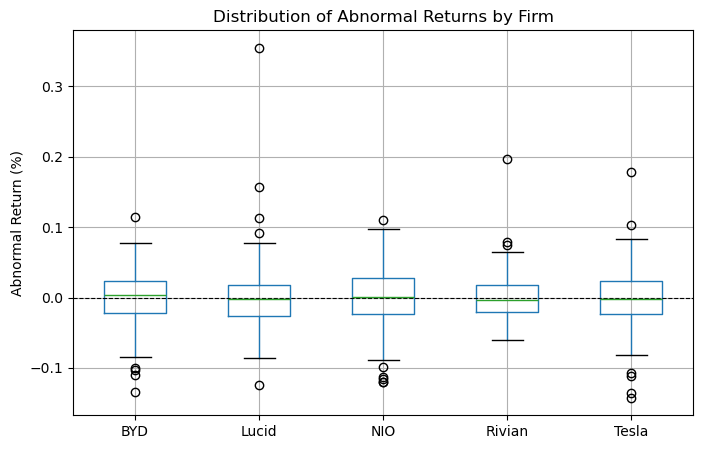

In [14]:
plt.figure(figsize=(8,5))
abret.boxplot()
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Distribution of Abnormal Returns by Firm")
plt.ylabel("Abnormal Return (%)")
plt.show()


In [15]:
from typing import Tuple, Optional

def nearest_trading_day(index: pd.DatetimeIndex, event_date: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Choose the trading day closest to event_date (weekends/holidays handled)."""
    if event_date in index:
        return event_date
    if len(index) == 0:
        return None
    # distance both directions, pick nearest; if tie, choose prior day
    diffs = (index - event_date).days.to_numpy()
    absdiff = np.abs(diffs)
    i = absdiff.argmin()
    # prefer prior if next is equally close
    ties = np.where(absdiff == absdiff[i])[0]
    if len(ties) > 1:
        # choose the one with negative diff (<= 0) if present
        prior = [t for t in ties if diffs[t] <= 0]
        if prior:
            i = prior[-1]
    return index[i]

def index_window(idx: pd.DatetimeIndex, center: pd.Timestamp, w: Tuple[int,int]) -> pd.DatetimeIndex:
    pos = idx.get_loc(center)
    start = max(0, pos + w[0])
    end   = min(len(idx)-1, pos + w[1])
    return idx[start:end+1]

def event_study(abret: pd.DataFrame, events: pd.DataFrame,
                event_window=(-5,5), car_window=(-1,1)):
    idx = abret.index
    aar_bucket = {}           # k -> list of ARs across firms & events
    ar_records = []           # rows of per-event, per-k, per-firm ARs
    car_records = []          # per-event per-firm CAR over car_window

    for _, ev in events.iterrows():
        ev_date = pd.to_datetime(ev["Date"])
        center = nearest_trading_day(idx, ev_date)
        if center is None:
            continue

        # --- AAR/CAAR stacking
        win_idx = index_window(idx, center, event_window)
        base = idx.get_loc(center)
        for d in win_idx:
            k = idx.get_loc(d) - base
            row = abret.loc[d].dropna()
            if row.empty: 
                continue
            # store firm ARs
            rec = {"event": ev["Headline"], "tag": ev["Tag"], "date": d, "k": k}
            rec.update(row.to_dict())
            ar_records.append(rec)
            # collect for AAR
            aar_bucket.setdefault(k, []).extend(row.values.tolist())

        # --- CAR (-1,+1)
        car_idx = index_window(idx, center, car_window)
        car_vals = abret.loc[car_idx].sum(axis=0)
        for firm, val in car_vals.items():
            car_records.append({
                "event": ev["Headline"], "tag": ev["Tag"], "ticker": firm, "car": float(val)
            })

    aar = pd.Series({k: np.mean(v) for k, v in aar_bucket.items()}).sort_index() if aar_bucket else pd.Series(dtype=float)
    caar = aar.cumsum() if not aar.empty else pd.Series(dtype=float)
    ar_stack = pd.DataFrame(ar_records)
    car_df = pd.DataFrame(car_records)

    return aar.rename("AAR"), caar.rename("CAAR"), ar_stack, car_df

AAR, CAAR, AR_stack, CAR = event_study(abret, events_df, event_window=(-5,5), car_window=(-1,1))

print("AAR\n", AAR.head(), "\n")
print("CAAR\n", CAAR.head(), "\n")
print("AR_stack\n", AR_stack.head(), "\n")
print("CAR\n", CAR.head())


AAR
 -5   -5.299978e-20
-4    4.265713e-19
-3    5.325198e-19
-2    2.152879e-19
-1   -5.590578e-19
Name: AAR, dtype: float64 

CAAR
 -5   -5.299978e-20
-4    3.735716e-19
-3    9.060913e-19
-2    1.121379e-18
-1    5.623214e-19
Name: CAAR, dtype: float64 

AR_stack
                                                event      tag       date  k  \
0  BOJ Is Said to Weigh Raising Inflation Forecas...  subsidy 2025-01-03 -5   
1  BOJ Is Said to Weigh Raising Inflation Forecas...  subsidy 2025-01-06 -4   
2  BOJ Is Said to Weigh Raising Inflation Forecas...  subsidy 2025-01-07 -3   
3  BOJ Is Said to Weigh Raising Inflation Forecas...  subsidy 2025-01-08 -2   
4  BOJ Is Said to Weigh Raising Inflation Forecas...  subsidy 2025-01-09 -1   

        BYD     Lucid       NIO    Rivian     Tesla  
0 -0.110323 -0.001708 -0.078387  0.196691 -0.006274  
1 -0.006630  0.014647  0.049973 -0.059298  0.001307  
2  0.044663 -0.024180  0.026869 -0.028724 -0.018627  
3  0.026712 -0.028173 -0.039394 -0.011429

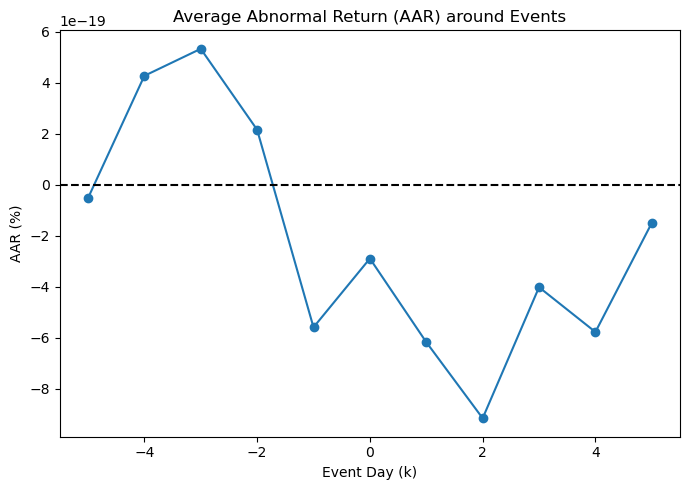

In [16]:

plt.figure(figsize=(7,5))
plt.plot(AAR.index, AAR.values, marker="o")
plt.axhline(0, color="black", linestyle="--")
plt.title("Average Abnormal Return (AAR) around Events")
plt.xlabel("Event Day (k)")
plt.ylabel("AAR (%)")
plt.tight_layout()
plt.show()

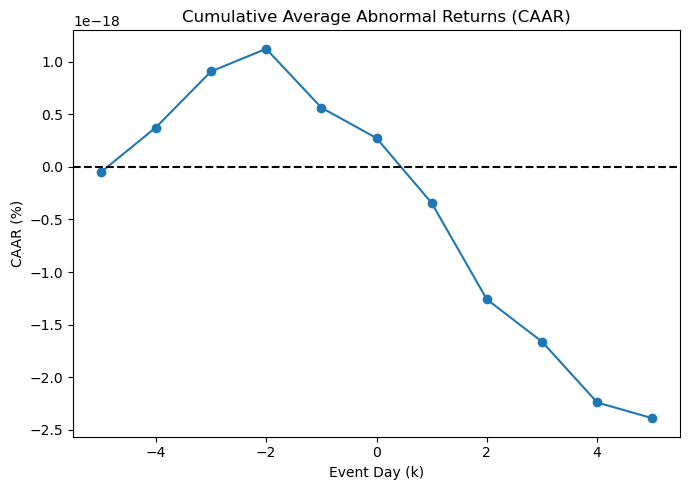

In [17]:
plt.figure(figsize=(7,5))
plt.plot(CAAR.index, CAAR.values, marker="o")
plt.axhline(0, color="black", linestyle="--")
plt.title("Cumulative Average Abnormal Returns (CAAR)")
plt.xlabel("Event Day (k)")
plt.ylabel("CAAR (%)")
plt.tight_layout()
plt.show()

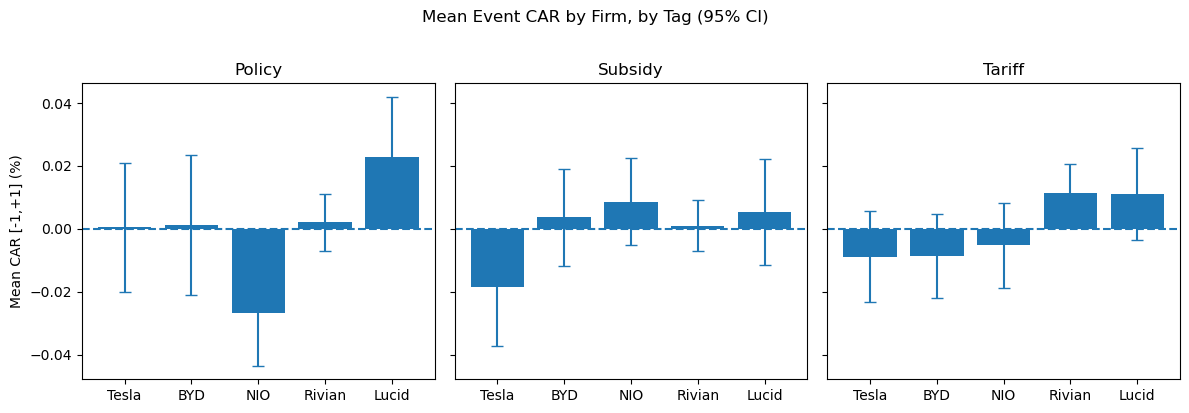

In [18]:
order = ["Tesla","BYD","NIO","Rivian","Lucid"]
tags = ["policy","subsidy","tariff"]

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
for ax, t in zip(axes, tags):
    sub = (CAR.loc[CAR["tag"]==t]
             .groupby("ticker")["car"].agg(["mean","std","count"])
             .reindex(order))
    sub["se"] = sub["std"]/np.sqrt(sub["count"])
    sub["ci95"] = 1.96*sub["se"]
    x = np.arange(len(order))
    ax.bar(x, sub["mean"].values)
    ax.errorbar(x, sub["mean"].values, yerr=sub["ci95"].values, fmt="none", capsize=4)
    ax.axhline(0, linestyle="--")
    ax.set_xticks(x); ax.set_xticklabels(order, rotation=0)
    ax.set_title(t.capitalize())
axes[0].set_ylabel("Mean CAR [-1,+1] (%)")
fig.suptitle("Mean Event CAR by Firm, by Tag (95% CI)", y=1.02)
plt.tight_layout()
plt.show()

In [19]:
def _per_firm_summary(car_df: pd.DataFrame) -> pd.DataFrame:
    def _agg(g):
        arr = g["car"].to_numpy(dtype=float)
        n = arr.size
        mean = np.nanmean(arr) if n else np.nan
        median = np.nanmedian(arr) if n else np.nan
        std = np.nanstd(arr, ddof=1) if n > 1 else np.nan
        pos_share = np.nan if n == 0 else np.mean(arr > 0)
        neg_share = np.nan if n == 0 else np.mean(arr < 0)
        # t-test H0: mean CAR = 0
        if n > 1 and np.isfinite(std):
            t_stat, p_val = stats.ttest_1samp(arr, popmean=0.0, nan_policy="omit")
        else:
            t_stat, p_val = np.nan, np.nan
        q10, q25, q75, q90 = (np.nanpercentile(arr, q) if n else np.nan for q in [10,25,75,90])
        return pd.Series({
            "n_events": n,
            "mean_car": mean,
            "median_car": median,
            "std_car": std,
            "p_val_mean_zero": p_val,
            "share_positive": pos_share,
            "share_negative": neg_share,
            "p10": q10, "p25": q25, "p75": q75, "p90": q90
        })
    out = car_df.groupby("ticker", dropna=False).apply(_agg).reset_index()
    # nicer ordering of tickers if desired
    order = ["Tesla", "BYD", "NIO", "Rivian", "Lucid"]
    out["sort_key"] = out["ticker"].apply(lambda x: order.index(x) if x in order else 999)
    out = out.sort_values(["sort_key", "ticker"]).drop(columns=["sort_key"])
    return out

summary_all = _per_firm_summary(CAR)

print("\n=== Per-firm CAR Summary across ALL policy/subsidy/tariff events (CAR window = [-1,+1]) ===")
with pd.option_context("display.float_format", "{:,.4f}".format):
    print(summary_all)


=== Per-firm CAR Summary across ALL policy/subsidy/tariff events (CAR window = [-1,+1]) ===
   ticker  n_events  mean_car  median_car  std_car  p_val_mean_zero  \
4   Tesla  177.0000   -0.0088     -0.0073   0.0682           0.0877   
0     BYD  177.0000   -0.0027     -0.0107   0.0650           0.5839   
2     NIO  177.0000   -0.0075     -0.0051   0.0595           0.0934   
3  Rivian  177.0000    0.0062      0.0089   0.0363           0.0248   
1   Lucid  177.0000    0.0129      0.0149   0.0652           0.0095   

   share_positive  share_negative     p10     p25    p75    p90  
4          0.3785          0.6215 -0.1020 -0.0533 0.0379 0.0747  
0          0.4124          0.5876 -0.0862 -0.0220 0.0378 0.0796  
2          0.4407          0.5593 -0.0896 -0.0334 0.0208 0.0469  
3          0.5819          0.4181 -0.0370 -0.0151 0.0257 0.0537  
1          0.6271          0.3729 -0.0626 -0.0199 0.0293 0.1133  


/var/folders/13/3qsjyhzx365f0qdkt8rlzvvh0000gn/T/ipykernel_35767/1791241525.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = car_df.groupby("ticker", dropna=False).apply(_agg).reset_index()


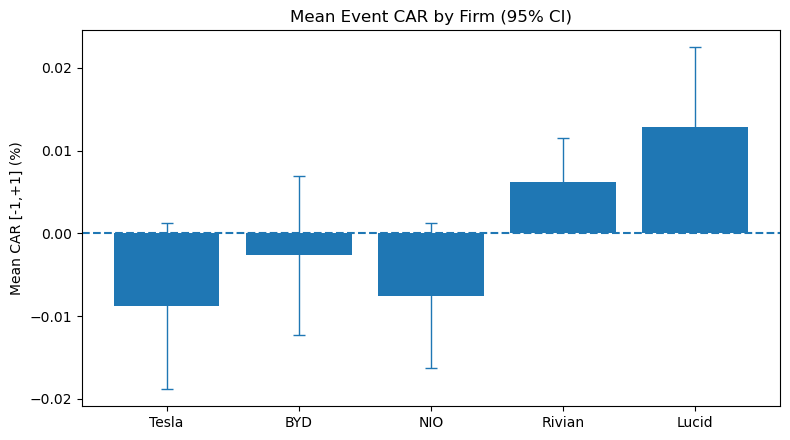

In [20]:
# Recompute mean, SE, 95% CI from the raw CARs (safer than relying on preprinted tables)
g = CAR.groupby("ticker")["car"]
stats_df = g.agg(["mean","std","count"]).reindex(["Tesla","BYD","NIO","Rivian","Lucid"])
stats_df["se"] = stats_df["std"] / np.sqrt(stats_df["count"])
stats_df["ci95"] = 1.96 * stats_df["se"]  # large-sample CI

plt.figure(figsize=(8,4.5))
x = np.arange(len(stats_df))
plt.bar(x, stats_df["mean"].values)
plt.errorbar(x, stats_df["mean"].values, yerr=stats_df["ci95"].values,
             fmt="none", capsize=4, linewidth=1)
plt.axhline(0, linestyle="--")
plt.xticks(x, stats_df.index.astype(str))
plt.ylabel("Mean CAR [-1,+1] (%)")
plt.title("Mean Event CAR by Firm (95% CI)")
plt.tight_layout()
plt.show()

/var/folders/13/3qsjyhzx365f0qdkt8rlzvvh0000gn/T/ipykernel_35767/1601284288.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=order, showmeans=True)


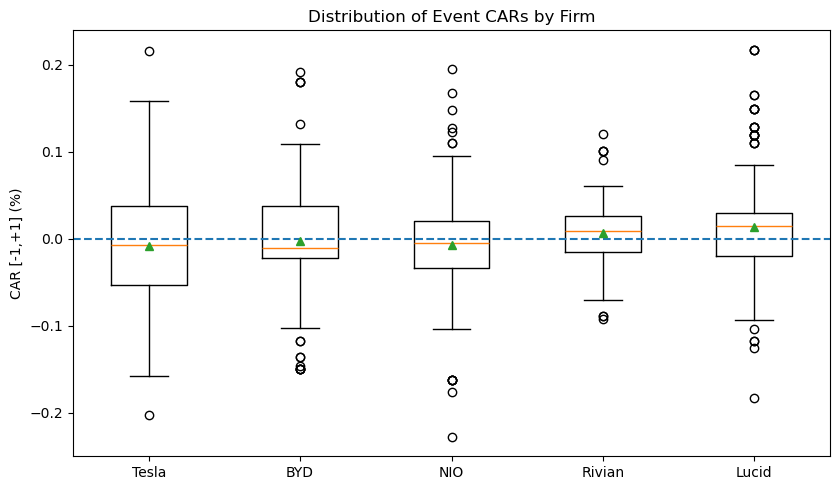

In [21]:
order = ["Tesla","BYD","NIO","Rivian","Lucid"]
plot_data = [CAR.loc[CAR["ticker"]==t, "car"].dropna().values for t in order]

plt.figure(figsize=(8.5,5))
plt.boxplot(plot_data, labels=order, showmeans=True)
plt.axhline(0, linestyle="--")
plt.ylabel("CAR [-1,+1] (%)")
plt.title("Distribution of Event CARs by Firm")
plt.tight_layout()
plt.show()

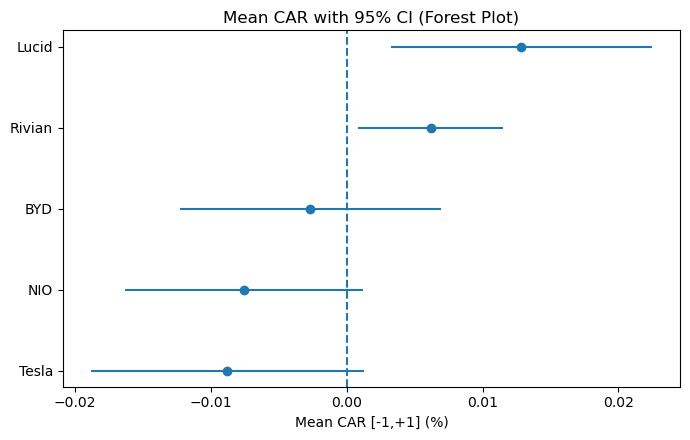

In [22]:
df = stats_df.copy().sort_values("mean")
y = np.arange(len(df))

plt.figure(figsize=(7,4.5))
plt.errorbar(df["mean"], y, xerr=df["ci95"], fmt="o")
plt.axvline(0, linestyle="--")
plt.yticks(y, df.index.astype(str))
plt.xlabel("Mean CAR [-1,+1] (%)")
plt.title("Mean CAR with 95% CI (Forest Plot)")
plt.tight_layout()
plt.show()


In [23]:
def _per_firm_by_tag(car_df: pd.DataFrame) -> pd.DataFrame:
    def _agg(g):
        arr = g["car"].to_numpy(dtype=float)
        n = arr.size
        mean = np.nanmean(arr) if n else np.nan
        median = np.nanmedian(arr) if n else np.nan
        pos_share = np.nan if n == 0 else np.mean(arr > 0)
        if n > 1:
            _, p_val = stats.ttest_1samp(arr, 0.0, nan_policy="omit")
        else:
            p_val = np.nan
        return pd.Series({"n_events": n, "mean_car": mean, "median_car": median, "share_positive": pos_share, "p_val_mean_zero": p_val})
    out = CAR.groupby(["tag","ticker"], dropna=False).apply(_agg).reset_index()
    order = ["policy", "subsidy", "tariff"]
    out["tag_sort"] = out["tag"].apply(lambda x: order.index(x) if x in order else 999)
    firm_order = ["Tesla", "BYD", "NIO", "Rivian", "Lucid"]
    out["ticker_sort"] = out["ticker"].apply(lambda x: firm_order.index(x) if x in firm_order else 999)
    out = out.sort_values(["tag_sort","ticker_sort"]).drop(columns=["tag_sort","ticker_sort"])
    return out

summary_by_tag = _per_firm_by_tag(CAR)

print("\n=== Per-firm CAR Summary BY TAG ===")
with pd.option_context("display.float_format", "{:,.4f}".format):
    print(summary_by_tag)



=== Per-firm CAR Summary BY TAG ===
        tag  ticker  n_events  mean_car  median_car  share_positive  \
4    policy   Tesla   49.0000    0.0004     -0.0073          0.3878   
0    policy     BYD   49.0000    0.0013     -0.0089          0.3878   
2    policy     NIO   49.0000   -0.0267     -0.0051          0.3469   
3    policy  Rivian   49.0000    0.0020      0.0067          0.5714   
1    policy   Lucid   49.0000    0.0230      0.0149          0.6531   
9   subsidy   Tesla   46.0000   -0.0185     -0.0079          0.4130   
5   subsidy     BYD   46.0000    0.0036     -0.0035          0.4348   
7   subsidy     NIO   46.0000    0.0087      0.0048          0.5870   
8   subsidy  Rivian   46.0000    0.0010     -0.0031          0.4565   
6   subsidy   Lucid   46.0000    0.0052      0.0102          0.6087   
14   tariff   Tesla   82.0000   -0.0089     -0.0073          0.3537   
10   tariff     BYD   82.0000   -0.0086     -0.0173          0.4146   
12   tariff     NIO   82.0000   -0.0052 

/var/folders/13/3qsjyhzx365f0qdkt8rlzvvh0000gn/T/ipykernel_35767/1233194031.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = CAR.groupby(["tag","ticker"], dropna=False).apply(_agg).reset_index()


In [24]:
def _narrative(df_all: pd.DataFrame) -> list[str]:
    bullets = []
    bullets.append("• Sector-wide averages (AAR/CAAR) are ~0 ⇒ no uniform reaction across all events.")
    for _, r in df_all.iterrows():
        bullets.append(
            f"• {r['ticker']}: mean CAR {r['mean_car']:+.2f}%, median {r['median_car']:+.2f}% "
            f"(positive on {r['share_positive']*100:.0f}% of events; n={int(r['n_events'])}; "
            f"t-test p={r['p_val_mean_zero']:.3f})"
        )
    return bullets

print("\n=== Slide-ready Narrative ===")
for line in _narrative(summary_all):
    print(line)



=== Slide-ready Narrative ===
• Sector-wide averages (AAR/CAAR) are ~0 ⇒ no uniform reaction across all events.
• Tesla: mean CAR -0.01%, median -0.01% (positive on 38% of events; n=177; t-test p=0.088)
• BYD: mean CAR -0.00%, median -0.01% (positive on 41% of events; n=177; t-test p=0.584)
• NIO: mean CAR -0.01%, median -0.01% (positive on 44% of events; n=177; t-test p=0.093)
• Rivian: mean CAR +0.01%, median +0.01% (positive on 58% of events; n=177; t-test p=0.025)
• Lucid: mean CAR +0.01%, median +0.01% (positive on 63% of events; n=177; t-test p=0.009)


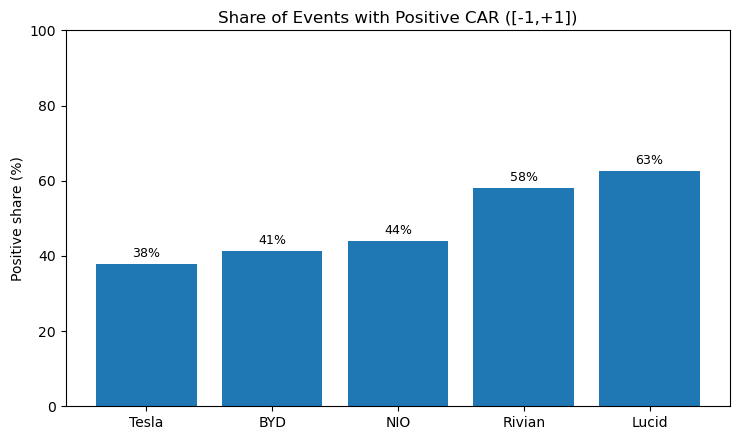

In [25]:
#Positive share bar chart by ticker
if not CAR.empty:
    pos_share = (CAR.assign(pos=lambda d: d["car"]>0)
                    .groupby("ticker")["pos"].mean()
                    .reindex(["Tesla","BYD","NIO","Rivian","Lucid"]))
    plt.figure(figsize=(7.5,4.5))
    plt.bar(pos_share.index.astype(str), (pos_share.values*100.0))
    plt.title("Share of Events with Positive CAR ([-1,+1])")
    plt.ylabel("Positive share (%)")
    plt.ylim(0, 100)
    for i, v in enumerate(pos_share.values*100.0):
        plt.text(i, v + 1, f"{v:.0f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

In [26]:
# export excel for the deck 
with pd.ExcelWriter("policy_event_study_summary.xlsx", engine="xlsxwriter") as writer:
    summary_all.to_excel(writer, sheet_name="Per-firm summary", index=False)
    summary_by_tag.to_excel(writer, sheet_name="Per-firm by tag", index=False)
    CAR.to_excel(writer, sheet_name="Event-level CAR", index=False)

print("\nSaved: policy_event_study_summary.xlsx (Per-firm summary, By-tag summary, Event-level CAR)")



Saved: policy_event_study_summary.xlsx (Per-firm summary, By-tag summary, Event-level CAR)


In [27]:
# Size buckets 
size_map = {"Tesla":"Big","BYD":"Big","NIO":"Small","Rivian":"Small","Lucid":"Small"}
CAR2 = CAR.copy()
CAR2["size"] = CAR2["ticker"].map(size_map)
CAR2["abs_car"] = CAR2["car"].abs()

In [28]:
# 1) Summary by size
summary_by_size = CAR2.groupby("size")["abs_car"].agg(["count","mean","median","std"]).sort_index()
print(summary_by_size)

       count      mean    median       std
size                                      
Big      354  0.050704  0.037867  0.043494
Small    531  0.038637  0.023472  0.040223


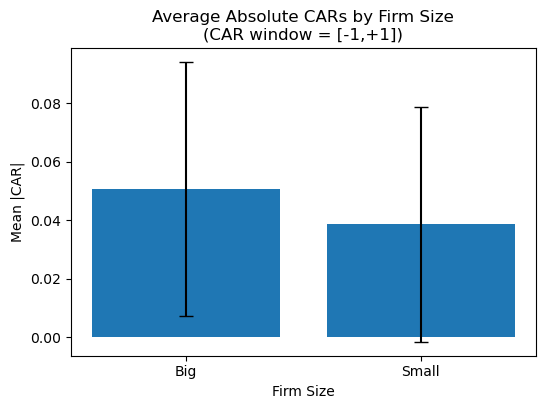

In [29]:
summary_stats = CAR2.groupby("size")["abs_car"].agg(["mean","std"]).reindex(["Big","Small"])

plt.figure(figsize=(6,4))
plt.bar(summary_stats.index, summary_stats["mean"], yerr=summary_stats["std"], capsize=5)
plt.title("Average Absolute CARs by Firm Size\n(CAR window = [-1,+1])")
plt.ylabel("Mean |CAR|")
plt.xlabel("Firm Size")
plt.show()


In [30]:
# 2) Welch t-test: Big vs Small on |CAR|
big = CAR2.loc[CAR2["size"]=="Big", "abs_car"].dropna()
small = CAR2.loc[CAR2["size"]=="Small","abs_car"].dropna()
t, p = stats.ttest_ind(big, small, equal_var=False, nan_policy="omit")
print(f"\nWelch t-test |CAR| (Big vs Small): t={t:.3f}, p={p:.4f}")


Welch t-test |CAR| (Big vs Small): t=4.166, p=0.0000


In [31]:
# 3) Robust check (Mann–Whitney)
u, p_u = stats.mannwhitneyu(big, small, alternative="two-sided")
print(f"Mann–Whitney |CAR| (Big vs Small): U={u:.0f}, p={p_u:.4f}")

Mann–Whitney |CAR| (Big vs Small): U=112535, p=0.0000


In [32]:
# 4) Regression: |CAR| on size bucket
CAR2 = CAR2.dropna(subset=["abs_car","size"]).copy()
CAR2["size"] = pd.Categorical(CAR2["size"], categories=["Small","Big"], ordered=True)
model = smf.ols("abs_car ~ C(size)", data=CAR2).fit(cov_type="HC1")
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                abs_car   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     17.36
Date:                Thu, 21 Aug 2025   Prob (F-statistic):           3.40e-05
Time:                        19:42:59   Log-Likelihood:                 1560.1
No. Observations:                 885   AIC:                            -3116.
Df Residuals:                     883   BIC:                            -3107.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0386      0.002     22.

In [33]:
# Load your supplier CSVs
file_map = {
    "CAtl.csv": "CATL",
    "GOTION.csv": "Gotion",
    "LG.csv": "LG Energy Solution",
    "Panasonic.csv": "Panasonic",
    "rio.csv": "Rio Tinto",
    "samsung.csv": "Samsung SDI",
}

In [34]:
sup_frames, missing = [], []

for fn, label in file_map.items():
    candidate_paths = [
        fn,
        os.path.join("./", fn),
        os.path.join("../", fn),
        os.path.join("/mnt/data", fn)
    ]
    found = next((p for p in candidate_paths if os.path.exists(p)), None)

    if found:
        df = pd.read_csv(found)

        # Try to find a date column
        date_col = next((c for c in df.columns if c.lower().strip() in ["date", "dt", "trade_date"]), None)
        if date_col is None:
            raise ValueError(f"No date column found in {found}")

        df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.normalize()

        # Try to find return column
        ret_col = next((c for c in df.columns if c.lower().strip() in 
                        ["chg_pct_1d","ret","return","daily_return","pct_change","pct_ret","change_pct"]), None)

        if ret_col is None:
            # If no return, try to compute from price
            px_col = next((c for c in df.columns if c.lower().strip() in ["px_last","close","adj_close","price"]), None)
            if px_col is None:
                raise ValueError(f"No return or price column found in {found}")
            df = df.sort_values(date_col)
            df["CHG_PCT_1D"] = df[px_col].pct_change() * 100.0
        else:
            df["CHG_PCT_1D"] = df[ret_col]

        # Keep only relevant columns
        out = pd.DataFrame({
            "Date": df[date_col],
            "Company": label,
            "CHG_PCT_1D": df["CHG_PCT_1D"]
        })

        sup_frames.append(out)

    else:
        missing.append(fn)

if missing:
    print("Warning: missing supplier files:", missing)

suppliers_df = pd.concat(sup_frames, ignore_index=True).sort_values(["Company", "Date"])


/var/folders/13/3qsjyhzx365f0qdkt8rlzvvh0000gn/T/ipykernel_35767/2954964304.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.normalize()
/var/folders/13/3qsjyhzx365f0qdkt8rlzvvh0000gn/T/ipykernel_35767/2954964304.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.normalize()
/var/folders/13/3qsjyhzx365f0qdkt8rlzvvh0000gn/T/ipykernel_35767/2954964304.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col

In [35]:
# ---------- 2) Build supplier abnormal returns (peer-adjusted within suppliers) ----------
sup_ret = (
    suppliers_df
    .pivot(index="Date", columns="Company", values="CHG_PCT_1D")
    .sort_index()
)

# convert percentage values to decimals
sup_ret = sup_ret / 100.0

abret_sup = peer_abnormal_returns(sup_ret)

In [36]:
#Get EV event-level CARs 
# Expect a DataFrame like: CAR[event, tag, ticker, car]
if "CAR" in globals():
    ev_car_df = CAR.copy()
else:
    ev_summary_xlsx = "policy_event_study_summary.xlsx"
    if os.path.exists(ev_summary_xlsx):
        ev_car_df = pd.read_excel(ev_summary_xlsx, sheet_name="Event-level CAR")
        # standardize expected columns
        ev_car_df = ev_car_df.rename(columns={
            next(k for k in ev_car_df.columns if k.lower()=="event"): "event",
            next(k for k in ev_car_df.columns if k.lower()=="tag"): "tag",
            next(k for k in ev_car_df.columns if k.lower() in ["ticker","ev","company"]): "ticker",
            next(k for k in ev_car_df.columns if re.sub(r"[^a-z]","",k.lower()) in ["car","carvalue","cumabret"]): "car",
        })
    else:
        raise RuntimeError("No EV CARs found. Either run your event-study (to create CAR) or place 'policy_event_study_summary.xlsx' with sheet 'Event-level CAR' in the working directory.")


In [37]:
# Align supplier dates to each event centre and compute supplier CARs 
# Need the EV event center (k=0) dates from your AR_stack
if "AR_stack" in globals():
    centers = (AR_stack.loc[AR_stack["k"]==0, ["event","date"]]
               .drop_duplicates().rename(columns={"date":"center_date"}))
else:
    raise RuntimeError("AR_stack not available to extract event center dates. Please re-run your event study code that produced AR_stack, or persist an event→date map.")

# Supplier CAR on [-1, +1] around center_date (mapped to supplier calendar)
sup_CAR_records = []
sup_idx = abret_sup.index

def nearest(idx: pd.DatetimeIndex, target: pd.Timestamp):
    if target in idx: return target
    if len(idx)==0: return None
    diffs = (idx - target).days.to_numpy()
    j = np.argmin(np.abs(diffs))
    # prefer prior if tie
    ties = np.where(np.abs(diffs)==np.abs(diffs[j]))[0]
    if len(ties)>1:
        prior = [t for t in ties if diffs[t] <= 0]
        if prior: j = prior[-1]
    return idx[j]

def idx_window(idx, center, w=(-1,1)):
    pos = idx.get_loc(center)
    a = max(0, pos + w[0]); b = min(len(idx)-1, pos + w[1])
    return idx[a:b+1]

events_df = (ev_car_df[["event","tag"]].drop_duplicates()
             .merge(centers, on="event", how="left").dropna(subset=["center_date"]))

for _, r in events_df.iterrows():
    ev, tg = r["event"], r["tag"]
    c = pd.to_datetime(r["center_date"])
    c_sup = nearest(sup_idx, c)
    if c_sup is None: 
        continue
    win = idx_window(sup_idx, c_sup, (-1,1))
    row_sum = abret_sup.loc[win].sum(axis=0)
    for firm, val in row_sum.items():
        sup_CAR_records.append({
            "event": ev,
            "tag": tg,
            "center_date": c,       # keep EV event center for clustering
            "supplier": firm,
            "car": float(val)
        })

SUP_CAR = pd.DataFrame(sup_CAR_records)


In [38]:
# Exposure weights: map EVs to suppliers
exposure = {
    "Panasonic": {"Tesla": 1.0},
    "LG Energy Solution": {"Tesla": 0.5, "Lucid": 0.5},
    "CATL": {"Tesla": 0.5, "NIO": 0.5},
    "Samsung SDI": {"Rivian": 1.0},
    "Gotion": {},  # fill if linked to your covered EVs; otherwise sector-average
    "Rio Tinto": {"Tesla": 0.2, "BYD": 0.2, "NIO": 0.2, "Rivian": 0.2, "Lucid": 0.2},
}

ev_car = ev_car_df.rename(columns={"ticker":"ev", "car":"ev_car"})

def weighted_ev_car_for_supplier(supplier: str) -> pd.DataFrame:
    weights = exposure.get(supplier, {})
    if not weights:
        # sector-average EV CAR
        return (ev_car.groupby(["event","tag"])["ev_car"].mean()
                      .reset_index().rename(columns={"ev_car":"w_ev_car"}))
    parts = []
    for ev_name, w in weights.items():
        parts.append(
            ev_car.loc[ev_car["ev"]==ev_name, ["event","tag","ev_car"]]
                  .assign(weight=w, contrib=lambda d: d["ev_car"]*d["weight"])
        )
    W = pd.concat(parts, ignore_index=True)
    W = (W.groupby(["event","tag"], as_index=False)["contrib"].sum()
           .rename(columns={"contrib":"w_ev_car"}))
    return W

In [39]:
# Helper: OLS with SEs clustered by event date 
def fit_clustered(df: pd.DataFrame):
    """
    Expects columns: sup_car, w_ev_car, center_date
    """
    m = smf.ols("sup_car ~ w_ev_car", data=df).fit(
        cov_type="cluster",
        cov_kwds={"groups": df["center_date"], "use_correction": True}  # small-sample correction
    )
    out = {
        "beta_spillover": m.params.get("w_ev_car", np.nan),
        "beta_se_cluster": m.bse.get("w_ev_car", np.nan),
        "beta_pval_cluster": m.pvalues.get("w_ev_car", np.nan),
        "r2": m.rsquared,
        "n_clusters": df["center_date"].nunique(),
        "n_rows": len(df),
    }
    return out, m

def make_left(df_sup_car, supplier):
    # Select the existing 'car' column and then rename to 'sup_car'
    left = df_sup_car.loc[df_sup_car["supplier"]==supplier,
                          ["event","tag","car","center_date"]].copy()
    left = left.rename(columns={"car":"sup_car"})
    return left


In [40]:
# Spillover regression: SUP_CAR ~ weighted EV CAR (CLUSTERED)
rows = []
models_by_supplier = {}
for sup in sorted(SUP_CAR["supplier"].unique()):
    left  = make_left(SUP_CAR, sup)   # <-- FIXED
    right = weighted_ev_car_for_supplier(sup)
    df = (left.merge(right, on=["event","tag"], how="inner")
              .dropna(subset=["sup_car","w_ev_car","center_date"]))
    if df.empty:
        continue
    stats_dict, model = fit_clustered(df)
    stats_dict.update({
        "supplier": sup,
        "mean_sup_car": df["sup_car"].mean(),
        "mean_weighted_ev_car": df["w_ev_car"].mean()
    })
    rows.append(stats_dict)
    models_by_supplier[sup] = model

spill_summary = pd.DataFrame(rows).sort_values("supplier")

print("\n=== Spillover regression (CLUSTERED by event date): Supplier CAR ~ Client-weighted EV CAR ([-1,+1]) ===")
with pd.option_context("display.float_format","{:.4f}".format):
    if not spill_summary.empty:
        print(spill_summary[["supplier","n_clusters","n_rows","beta_spillover",
                             "beta_se_cluster","beta_pval_cluster","r2",
                             "mean_sup_car","mean_weighted_ev_car"]])
    else:
        print("No results (empty).")



=== Spillover regression (CLUSTERED by event date): Supplier CAR ~ Client-weighted EV CAR ([-1,+1]) ===
             supplier  n_clusters  n_rows  beta_spillover  beta_se_cluster  \
0                CATL          81     159         -0.0656           0.0979   
1              Gotion          81     159         -0.0000           0.0000   
2  LG Energy Solution          81     159         -0.0290           0.0772   
3           Panasonic          81     159          0.0640           0.0584   
4           Rio Tinto          81     159          0.0000           0.0000   
5         Samsung SDI          81     159         -0.0408           0.1055   

   beta_pval_cluster      r2  mean_sup_car  mean_weighted_ev_car  
0             0.5031  0.0105        0.0056               -0.0086  
1             0.8103 -0.0000        0.0010               -0.0000  
2             0.7068  0.0019        0.0046                0.0011  
3             0.2734  0.0125       -0.0071               -0.0098  
4            

In [41]:
# BY TAG splits (CLUSTERED) 
bytag_rows = []
for sup in sorted(SUP_CAR["supplier"].unique()):
    left  = make_left(SUP_CAR, sup)   # <-- FIXED
    right = weighted_ev_car_for_supplier(sup)
    merged = (left.merge(right, on=["event","tag"], how="inner")
                   .dropna(subset=["sup_car","w_ev_car","center_date"]))
    for tg in ["policy","subsidy","tariff"]:
        df = merged.loc[merged["tag"]==tg].copy()
        if df["center_date"].nunique() < 10:
            continue
        stats_dict, _ = fit_clustered(df)
        stats_dict.update({"supplier": sup, "tag": tg, "n_clusters": df["center_date"].nunique()})
        bytag_rows.append(stats_dict)
        

spill_by_tag = pd.DataFrame(bytag_rows).sort_values(["supplier","tag"])

print("\n=== Spillover BY TAG (CLUSTERED by event date) ===")
with pd.option_context("display.float_format","{:.4f}".format):
    if not spill_by_tag.empty:
        print(spill_by_tag[["supplier","tag","n_clusters","n_rows",
                            "beta_spillover","beta_se_cluster","beta_pval_cluster","r2"]])
    else:
        print("Insufficient clusters per tag to estimate.")


=== Spillover BY TAG (CLUSTERED by event date) ===
              supplier      tag  n_clusters  n_rows  beta_spillover  \
0                 CATL   policy          31      43         -0.1259   
1                 CATL  subsidy          31      44         -0.1710   
2                 CATL   tariff          51      72          0.0096   
3               Gotion   policy          31      43          0.0000   
4               Gotion  subsidy          31      44         -0.0000   
5               Gotion   tariff          51      72         -0.0000   
6   LG Energy Solution   policy          31      43          0.0423   
7   LG Energy Solution  subsidy          31      44         -0.1305   
8   LG Energy Solution   tariff          51      72         -0.0711   
9            Panasonic   policy          31      43          0.1464   
10           Panasonic  subsidy          31      44          0.0043   
11           Panasonic   tariff          51      72          0.0362   
12           Rio Tinto   

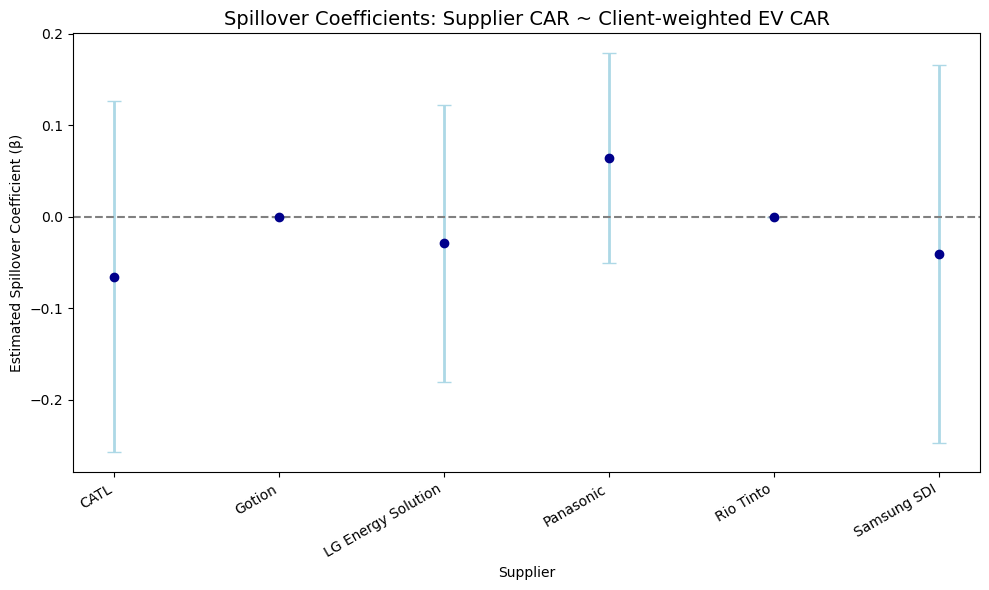

In [42]:
# Sort suppliers for consistent order
spill_summary_sorted = spill_summary.sort_values("supplier")

# Extract values
suppliers = spill_summary_sorted["supplier"]
coef = spill_summary_sorted["beta_spillover"]
se = spill_summary_sorted["beta_se_cluster"]

# 95% confidence interval
ci_low = coef - 1.96 * se
ci_high = coef + 1.96 * se

# Plot
plt.figure(figsize=(10,6))
plt.errorbar(
    suppliers, coef, 
    yerr=1.96*se, fmt='o', capsize=5, 
    color="darkblue", ecolor="lightblue", elinewidth=2
)
plt.axhline(0, color="grey", linestyle="--")
plt.title("Spillover Coefficients: Supplier CAR ~ Client-weighted EV CAR", fontsize=14)
plt.ylabel("Estimated Spillover Coefficient (β)")
plt.xlabel("Supplier")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


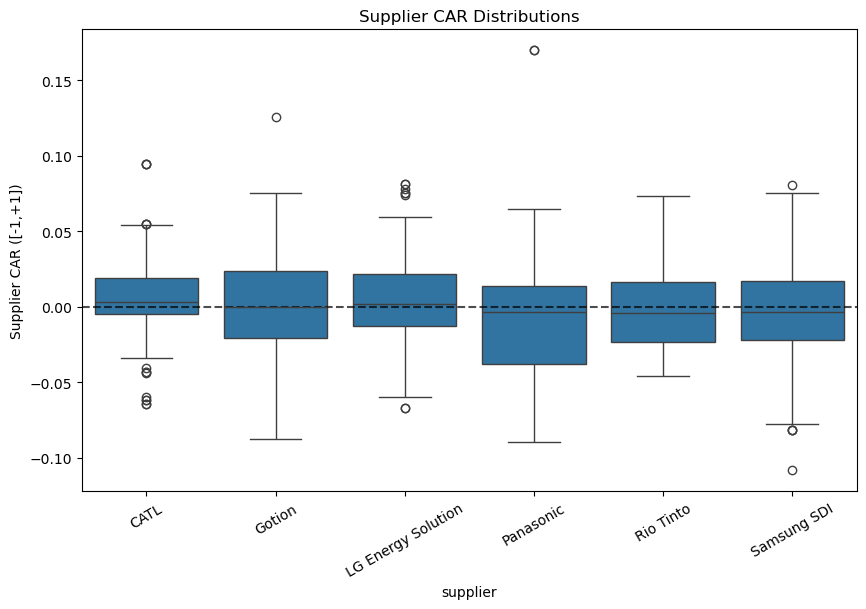

In [43]:

plt.figure(figsize=(10,6))
sns.boxplot(data=SUP_CAR, x="supplier", y="car")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.ylabel("Supplier CAR ([-1,+1])")
plt.title("Supplier CAR Distributions")
plt.xticks(rotation=30)
plt.show()